In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load datasets

In [3]:
df1 = pd.read_csv("matches.csv", encoding="unicode_escape") 

In [4]:
df2 = pd.read_csv("deliveries.csv", encoding="unicode_escape")

In [5]:
print(df1.shape, df2.shape)

(636, 18) (150460, 21)


Strip whitespaces in string columns

In [6]:
for col in df1.select_dtypes(include="object").columns:
    df1[col] = df1[col].str.strip()

for col in df2.select_dtypes(include="object").columns:
    df2[col] = df2[col].str.strip()

Standardize team names

In [7]:
team_map = {
    "Delhi Daredevils": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants"
}

for col in ["team1","team2","toss_winner","winner"]:
    if col in df1.columns:
        df1[col] = df1[col].replace(team_map)

for col in ["batting_team","bowling_team"]:
    if col in df2.columns:
        df2[col] = df2[col].replace(team_map)

Convert numeric columns

In [8]:
num_cols = ["wide_runs","noball_runs","bye_runs","legbye_runs",
            "batsman_runs","extra_runs","total_runs"]

for col in num_cols:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors="coerce").fillna(0).astype(int)

Add helper columns

In [9]:
df2["legal_delivery"] = ((df2["wide_runs"]==0) & (df2["noball_runs"]==0))
df2["runs_conceded"] = df2["total_runs"] - df2["bye_runs"] - df2["legbye_runs"]

Merge season into deliveries

In [10]:
df2 = df2.merge(df1[["id","season"]], left_on="match_id", right_on="id", how="left")

Export cleaned files

In [11]:
df1.to_csv("matches_cleaned.csv", index=False)
df2.to_csv("deliveries_cleaned.csv", index=False)

Data Visualization

1. Top 10 Run Scorers

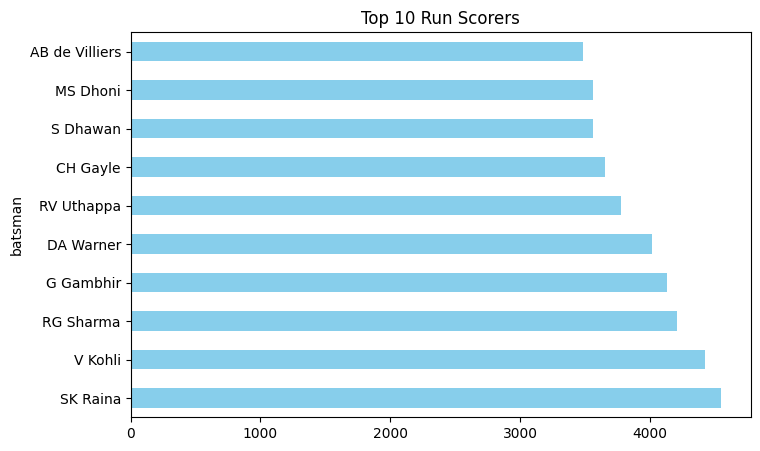

In [12]:
top_runs = df2.groupby("batsman")["batsman_runs"].sum().nlargest(10)
top_runs.plot(kind="barh", figsize=(8,5), color="skyblue", title="Top 10 Run Scorers")
plt.show()

2. Top 10 Wicket Takers

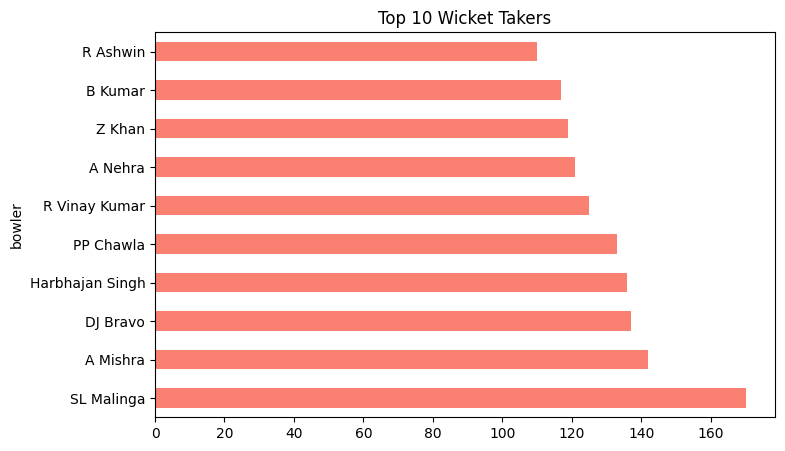

In [13]:
bowling_wickets = df2[df2["player_dismissed"].notna()].groupby("bowler").size().nlargest(10)
bowling_wickets.plot(kind="barh", figsize=(8,5), color="salmon", title="Top 10 Wicket Takers")
plt.show()

3. Most Fours by Players

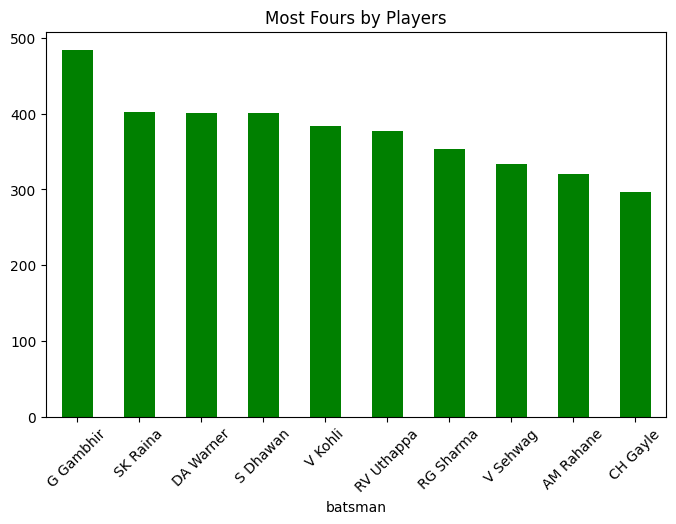

In [14]:
fours = df2[df2["batsman_runs"]==4].groupby("batsman").size().nlargest(10)
fours.plot(kind="bar", figsize=(8,5), color="green", title="Most Fours by Players")
plt.xticks(rotation=45)
plt.show()

4. Most Sixes by Players

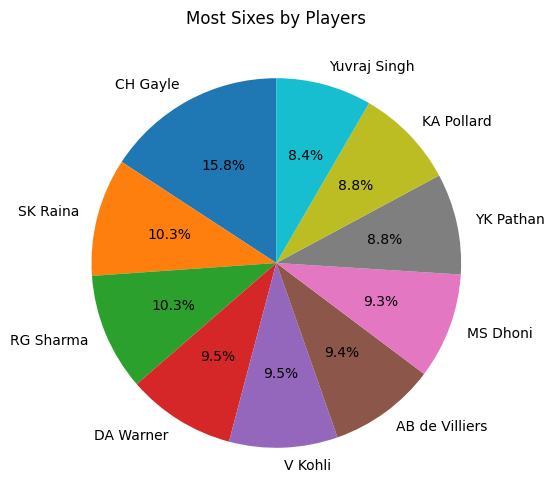

In [18]:
sixes = df2[df2["batsman_runs"]==6].groupby("batsman").size().nlargest(10)
sixes.plot(kind="pie", autopct="%1.1f%%", figsize=(6,6), startangle=90)
plt.title("Most Sixes by Players")
plt.ylabel("")
plt.show()

5. Strike Rate of Top Players (200+ balls)

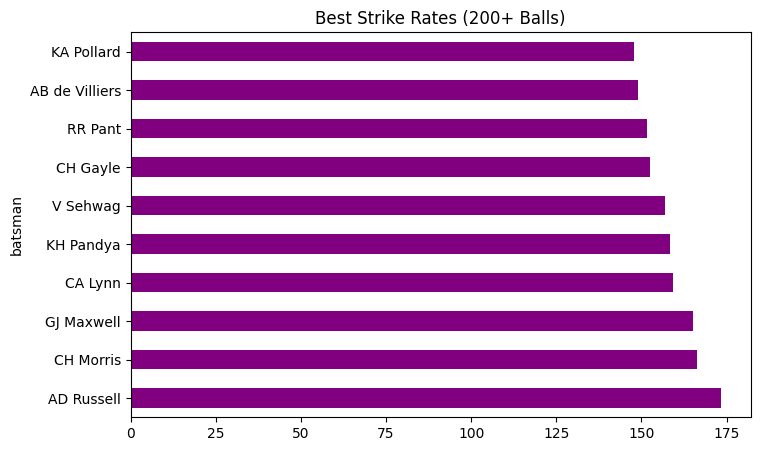

In [22]:
batting_summary = df2.groupby("batsman").agg(Runs=("batsman_runs","sum"), Balls=("legal_delivery","sum"))
batting_summary["SR"] = (batting_summary["Runs"]/batting_summary["Balls"]*100).round(2)
sr_top = batting_summary[batting_summary["Balls"]>200].nlargest(10,"SR")
sr_top["SR"].plot(kind="barh", figsize=(8,5), color="purple", title="Best Strike Rates (200+ Balls)")
plt.show()

6. Best Economies (min 300 balls)

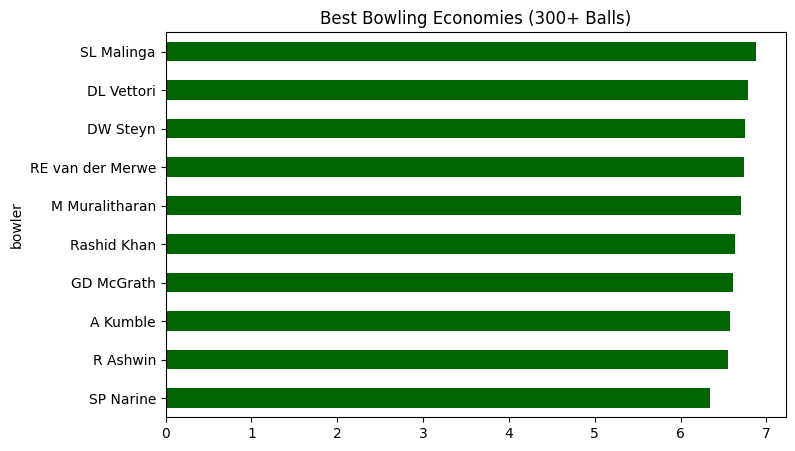

In [23]:
bowling_summary = df2.groupby("bowler").agg(RunsConceded=("runs_conceded","sum"), Balls=("legal_delivery","sum"))
bowling_summary["Economy"] = (bowling_summary["RunsConceded"]/(bowling_summary["Balls"]/6)).round(2)
eco = bowling_summary[bowling_summary["Balls"]>300].nsmallest(10,"Economy")
eco["Economy"].plot(kind="barh", figsize=(8,5), color="darkgreen", title="Best Bowling Economies (300+ Balls)")
plt.show()

7. Matches per Venue

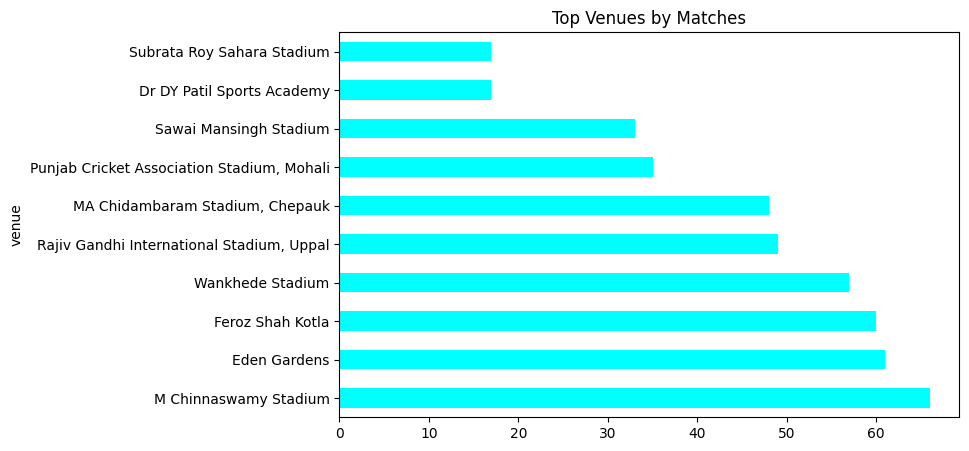

In [24]:
venue_counts = df1["venue"].value_counts().head(10)
venue_counts.plot(kind="barh", figsize=(8,5), color="cyan", title="Top Venues by Matches")
plt.show()

8. Matches per City

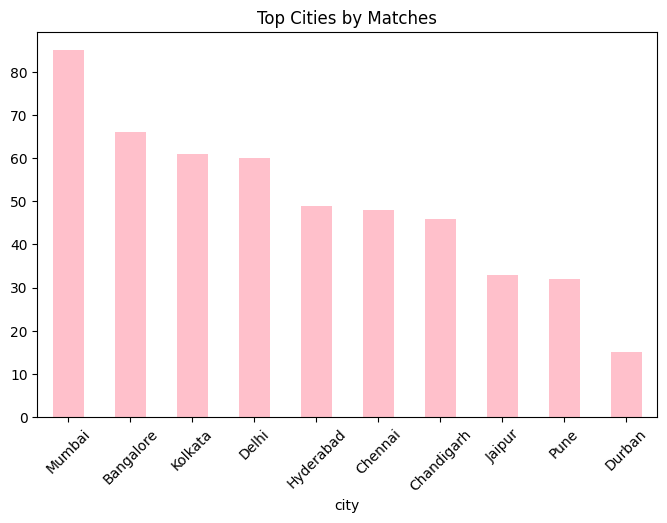

In [37]:
city_counts = df1["city"].value_counts().head(10)
city_counts.plot(kind="bar", figsize=(8,5), color="pink", title="Top Cities by Matches")
plt.xticks(rotation=45)
plt.show()

9. Toss Decision Count

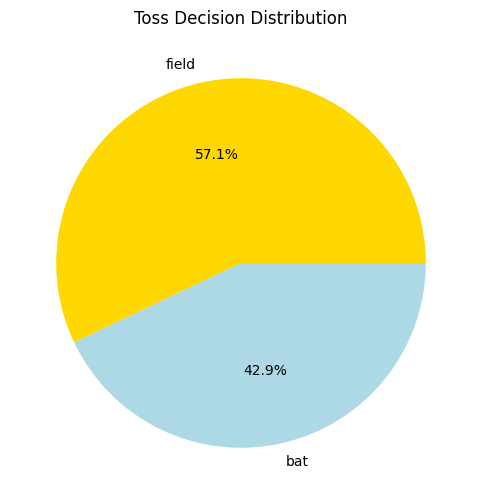

In [26]:
df1["toss_decision"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(6,6), colors=["gold","lightblue"])
plt.title("Toss Decision Distribution")
plt.ylabel("")
plt.show()

10. Win After Toss %

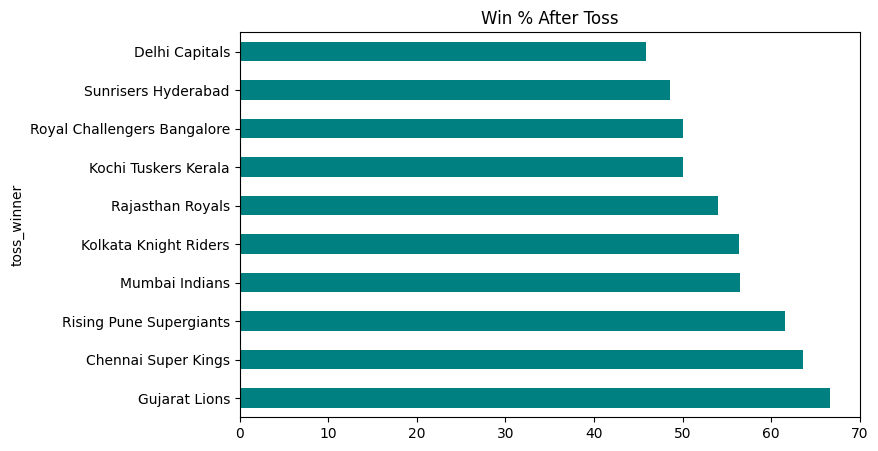

In [27]:
toss = df1.copy()
toss["WonAfterToss"] = toss["toss_winner"]==toss["winner"]
toss_stats = toss.groupby("toss_winner")["WonAfterToss"].mean().nlargest(10)*100
toss_stats.plot(kind="barh", figsize=(8,5), color="teal", title="Win % After Toss")
plt.show()

11. Team Wins

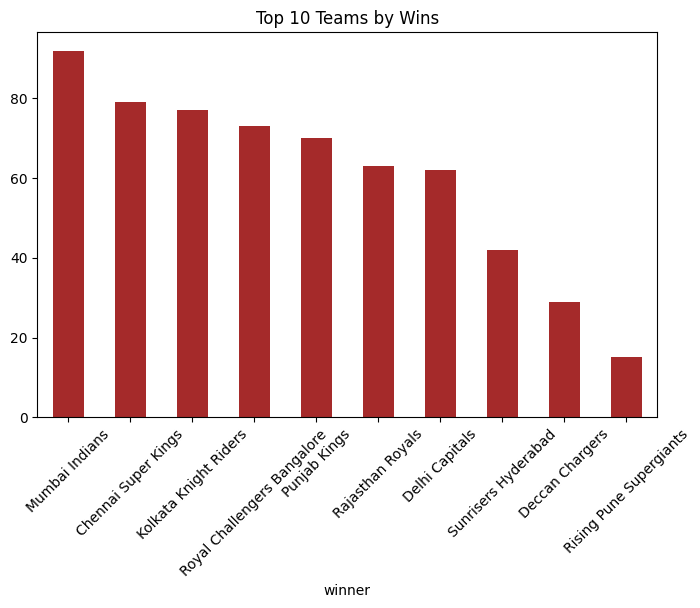

In [35]:
wins = df1["winner"].value_counts().head(10)
wins.plot(kind="bar", figsize=(8,5), color="brown", title="Top 10 Teams by Wins")
plt.xticks(rotation=45)
plt.show()

12. Matches per Season

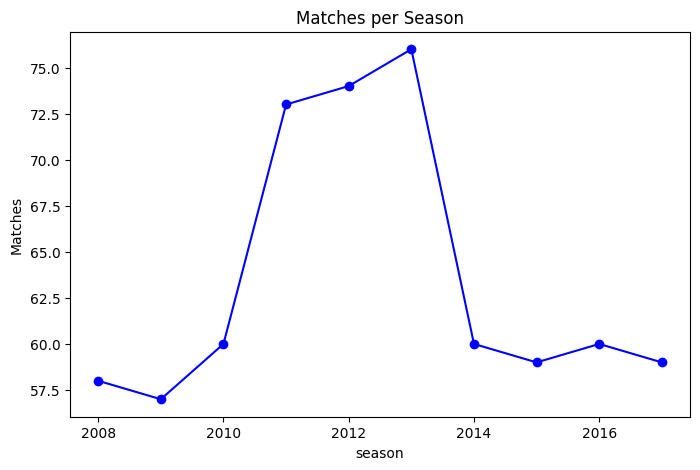

In [29]:
season_matches = df1["season"].value_counts().sort_index()
season_matches.plot(kind="line", marker="o", figsize=(8,5), color="blue", title="Matches per Season")
plt.ylabel("Matches")
plt.show()

13. Average Runs per Season

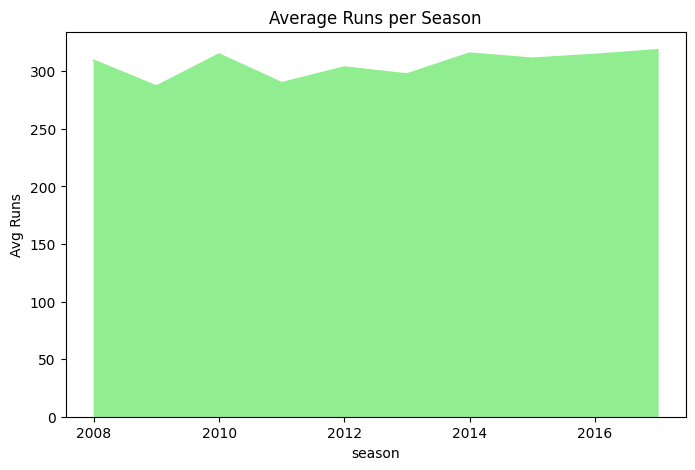

In [30]:
avg_runs = df2.groupby("season")["total_runs"].sum() / df2.groupby("season")["match_id"].nunique()
avg_runs.plot(kind="area", figsize=(8,5), color="lightgreen", title="Average Runs per Season")
plt.ylabel("Avg Runs")
plt.show()

14. Top Fielders

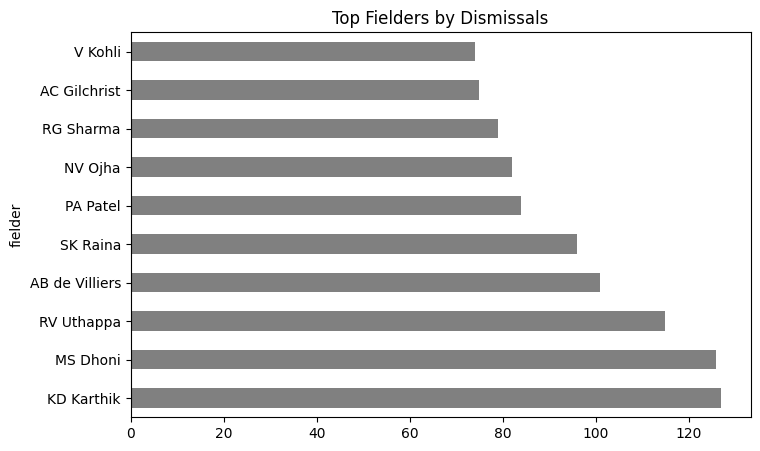

In [31]:
fielders = df2[df2["player_dismissed"].notna()].groupby("fielder").size().nlargest(10)
fielders.plot(kind="barh", figsize=(8,5), color="grey", title="Top Fielders by Dismissals")
plt.show()

15. Player of the Match Awards

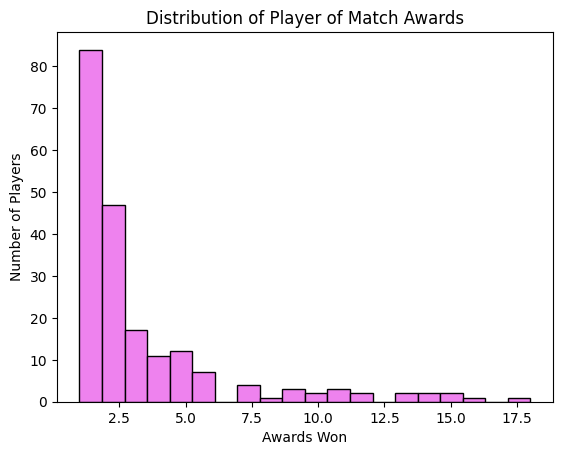

In [33]:
pom_counts = df1["player_of_match"].value_counts()
plt.hist(pom_counts, bins=20, color="violet", edgecolor="black")
plt.title("Distribution of Player of Match Awards")
plt.xlabel("Awards Won")
plt.ylabel("Number of Players")
plt.show()